## Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

from typing import List, Callable

## Table of Contents

- [Data Preperation](#data-preperation)
- [Naive Model](#naive-model)
- [AutoRegression Model](#autoregression-model)
- [SARIMAX model](#sarimax-model)

## Data Preperation
Load and split the time series data into train/test sets.

In [9]:
# Loading pickled dataframe
PICKLE_PATH = "../data/apex"
df = pd.read_pickle(PICKLE_PATH)
df['ds'] = df['date']
df = df.set_index(keys="date").resample("H").pad()
df

C:\Users\salim\AppData\Local\Temp\ipykernel_17840\2410496073.py:5: FutureWarning: pad is deprecated and will be removed in a future version. Use ffill instead.
  df = df.set_index(keys="date").resample("H").pad()


,players,twitch_viewers,date_interval,change_in_players,sma,std,day,hour,ds
date,,,,,,,,,
2022-06-03 03:00:00,157067,69159,0 days 00:10:00,1259,NaN,NaN,Fri,3,2022-06-03 03:00:00
2022-06-03 04:00:00,159168,77259,0 days 00:10:00,-18,NaN,NaN,Fri,4,2022-06-03 04:00:00
2022-06-03 05:00:00,172103,67744,0 days 00:10:00,2704,NaN,NaN,Fri,5,2022-06-03 05:00:00
2022-06-03 06:00:00,191923,51578,0 days 00:10:00,2771,NaN,NaN,Fri,6,2022-06-03 06:00:00
2022-06-03 07:00:00,204307,47960,0 days 00:10:00,1638,NaN,NaN,Fri,7,2022-06-03 07:00:00
...,...,...,...,...,...,...,...,...,...
2022-06-16 22:00:00,103678,55915,0 days 00:10:00,-1920,173763.516865,3.738793e+09,Thu,22,2022-06-16 22:00:00
2022-06-16 23:00:00,97250,55317,0 days 00:10:00,-1084,173756.799603,3.739784e+09,Thu,23,2022-06-16 23:00:00
2022-06-17 00:00:00,99135,54288,0 days 00:10:00,422,173748.781746,3.740993e+09,Fri,0,2022-06-17 00:00:00


In [10]:
# Setting seaborn figure size
sns.set(rc={'figure.figsize':(11.7,8.27)})

Split the time series into a train and split part since we need a feature that we are predicting for. Unlike the typical random selection of train/test splits we can't do that with time series data. Hence we'll take a specific number of value from the beginning of the time series as the train split and the rest will be our test split.

In [11]:
TRAIN_SIZE = df.players.shape[0] - 30

# Splitting the dataframe into train and test sets
df['train'] = df.players[:TRAIN_SIZE]
df['test'] = df.players[TRAIN_SIZE:]

Text(0.5, 1.0, 'Player Activity Train and Test Sets')

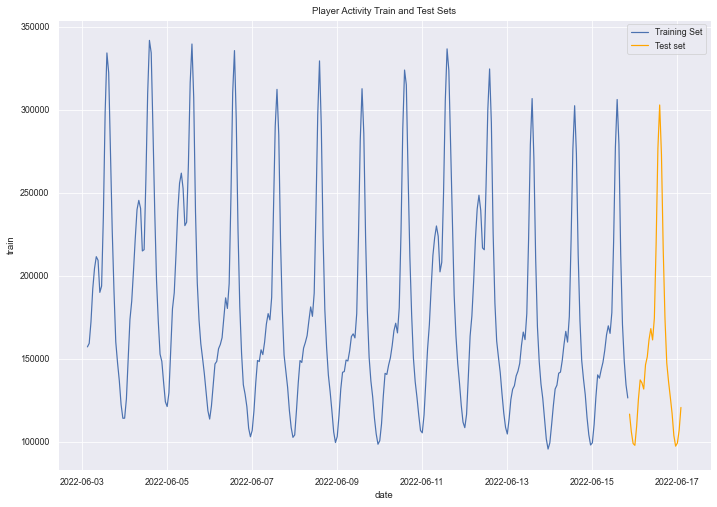

In [12]:
sns.set_theme("paper")
fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test set")

fig.set_title("Player Activity Train and Test Sets")

## Naive Model

When forecasting we will need a baseline to compare the performance of our model which we'll use y<sub>n+1</sub> = y<sub>n</sub> model as our naive base model.

In [13]:
# Predictions using the naive model
preds = np.repeat(df.train.dropna()[-1:], df.shape[0]-TRAIN_SIZE)

# All the predictions stored into the dataframe
#df['naive_pred'] = np.repeat(np.nan, TRAIN_SIZE) + preds
df['naive_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds
df

,players,twitch_viewers,date_interval,change_in_players,sma,std,day,hour,ds,train,test,naive_pred
date,,,,,,,,,,,,
2022-06-03 03:00:00,157067,69159,0 days 00:10:00,1259,NaN,NaN,Fri,3,2022-06-03 03:00:00,157067.0,NaN,NaN
2022-06-03 04:00:00,159168,77259,0 days 00:10:00,-18,NaN,NaN,Fri,4,2022-06-03 04:00:00,159168.0,NaN,NaN
2022-06-03 05:00:00,172103,67744,0 days 00:10:00,2704,NaN,NaN,Fri,5,2022-06-03 05:00:00,172103.0,NaN,NaN
2022-06-03 06:00:00,191923,51578,0 days 00:10:00,2771,NaN,NaN,Fri,6,2022-06-03 06:00:00,191923.0,NaN,NaN
2022-06-03 07:00:00,204307,47960,0 days 00:10:00,1638,NaN,NaN,Fri,7,2022-06-03 07:00:00,204307.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-16 22:00:00,103678,55915,0 days 00:10:00,-1920,173763.516865,3.738793e+09,Thu,22,2022-06-16 22:00:00,NaN,103678.0,126297.0
2022-06-16 23:00:00,97250,55317,0 days 00:10:00,-1084,173756.799603,3.739784e+09,Thu,23,2022-06-16 23:00:00,NaN,97250.0,126297.0
2022-06-17 00:00:00,99135,54288,0 days 00:10:00,422,173748.781746,3.740993e+09,Fri,0,2022-06-17 00:00:00,NaN,99135.0,126297.0


In [14]:
# Computes the root mean square error
rmse = lambda actual, predicated: np.sqrt(mean_squared_error(actual, predicated))

# Computes the mean percentage error and root mean square error for naive model
naive_rmse = rmse(df.test[TRAIN_SIZE:], df.naive_pred[TRAIN_SIZE:]) 
naive_mape = mean_absolute_percentage_error(df.test[TRAIN_SIZE:], df.naive_pred[TRAIN_SIZE:])

The metric `root mean squared error` can be thought of as how wrong the prediction will be off by on average. Not surprisingly the RMSE is 124220 which means that the naive model is going to be off by a large amount.

We decide to use the `mean absolute percentage error` which we can think of as the analogous version of the accuracy metric for classification models. The naive model has a 89% mean absolute percentage error which is quite a lot. One can think of this as essentially having 11% accuracy. 

Text(0.5, 1.0, 'Player Activity Predictation: RMSE: 59839.81, MAPE: 0.22')

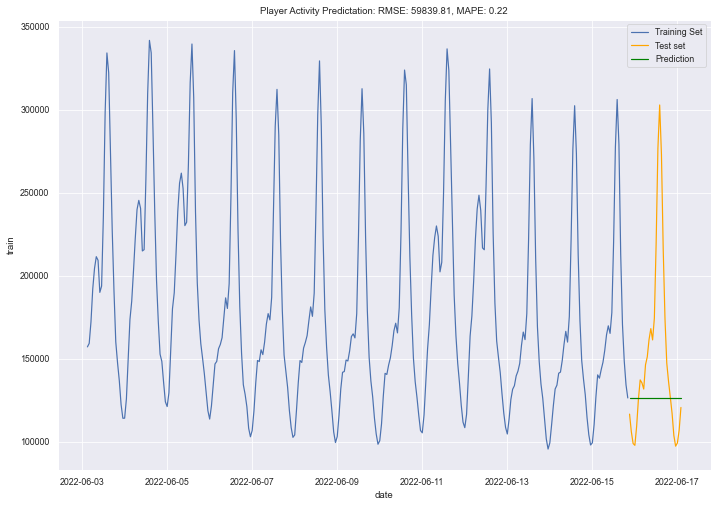

In [15]:
sns.set_theme("paper")
fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test set")
sns.lineplot(data=df.naive_pred, color="green", label="Prediction")

fig.set_title(f"Player Activity Predictation: RMSE: {naive_rmse:.2f}, MAPE: {naive_mape:.2f}")

## Evaluate Model Performance

Implement `cross validation` for time series since we can not randomly choose samples and assign them for test or train sets due to our data being dependent on time. We use a handy function known as `TimeSeriesSplit` from sklearn to handle the splitting of our data.

In [16]:
def naive_model(train: pd.DataFrame, test: pd.DataFrame) -> List[any]:
    """ This is the baseline model to compare the performance of other models. It is a model that assumes
    that the next values of the time series will be whatever the previous value was. (y_n+1 = y_n) 

    Args:
        train (pd.DataFrame): The time series feature that we are interested in prediction.
        test (pd.DataFrame): The test data which we need just for the number of predictions.

    Returns:
        List[any]: Return the prediction as a list.
    """

    return np.repeat(train[-1:], test.shape[0])

In [17]:
def eval_model_perf(df: pd.DataFrame , model: Callable[[pd.DataFrame, pd.DataFrame], List[any]]) -> None:
    """ Evaluates the performance of a model using RMSE and MAPE.

    Args:
        model (_type_): _description_
    """
    rmse_metrics = []
    mape_metrics = []

    tscv = TimeSeriesSplit(n_splits=4)

    for train_index, test_index in tscv.split(df):

        cv_train = df.iloc[train_index]
        cv_test = df.iloc[test_index]

        preds = model(cv_train, cv_test)

        rmse_eval = rmse(cv_test, preds) 
        naive_eval = mean_absolute_percentage_error(cv_test, preds)

        rmse_metrics.append(rmse_eval)
        mape_metrics.append(naive_eval)


    print("Cross Validation Results: ")
    print(f"RMSE: {np.mean(rmse_metrics)}")
    print(f"MAPE: {np.mean(mape_metrics)}")

In [18]:
# Evaluating the performance of the naive model using cross validation
eval_model_perf(df.players, naive_model)

    

Cross Validation Results: 
RMSE: 72796.92541950871
MAPE: 0.3584343608656596


## AutoRegression Model

In [19]:
from statsmodels.tsa.ar_model import AutoReg
from pmdarima import auto_arima

model = AutoReg(df.train.dropna(), 3, old_names=False, seasonal=True, period=24)
model = model.fit()

preds = model.predict(start=len(df.train.dropna()), end=len(df.players)-1)
#print(preds)
# All the predictions stored into the dataframe
df['autoreg_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds

Text(0.5, 1.0, 'Apex Player Activity Predictation: RMSE: 17147.87, MAPE: 0.09')

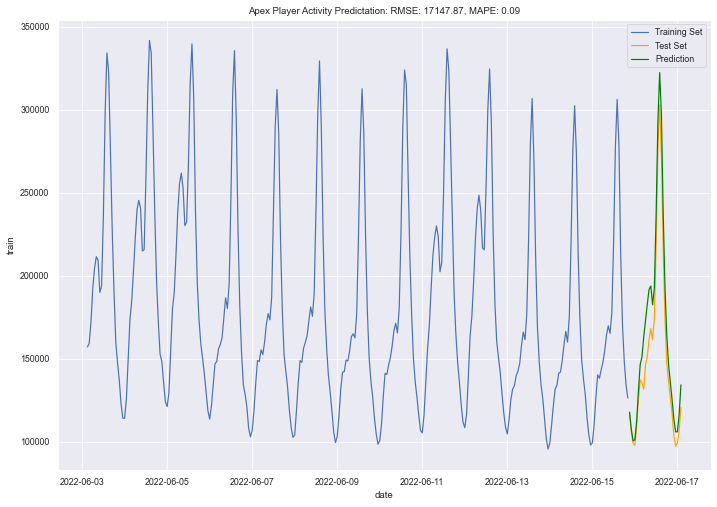

In [20]:
# Computes the mean percentage error and root mean square error for AutoRegression model
autoreg_rmse = rmse(df.test[TRAIN_SIZE:], df.autoreg_pred[TRAIN_SIZE:]) 
autoreg_mape = mean_absolute_percentage_error(df.test[TRAIN_SIZE:], df.autoreg_pred[TRAIN_SIZE:])

fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test Set")
sns.lineplot(data=df.autoreg_pred, color="green", label="Prediction")

fig.set_title(f"Apex Player Activity Predictation: RMSE: {autoreg_rmse:.2f}, MAPE: {autoreg_mape:.2f}")

Cross validation to evaluate the performance of the naive model.

In [21]:
def autoregression_model(train, test):

    # Training the autogression model
    model = AutoReg(train.dropna(), 3, old_names=False, seasonal=True, period=24)
    model = model.fit()

    # Make predictions
    preds = model.predict(start=len(train), end=len(train)+len(test)-1)

    return preds

eval_model_perf(df.players, autoregression_model)




Cross Validation Results: 
RMSE: 25383.09522940171
MAPE: 0.12795825044707737


The autogression model is performing well as our MAPE is 0.127 or in another words about 87.3% accuracy. On average the predictions are off by ~25000. This suggests that the first initial train/test evaluation was better than most train/test splits. This is why we do cross validation to make sure that our train/test does happen to give us good evaluations for our metrics by chance. 

## ARIMA Model

One approach to time series forecasting is using `ARIMA models`. This type of model aims to describe the autocorrelations in the data. Similar to a multiple linear regression model where we use a linear combination of predictors but instead we use linear combination of the past values.

In [22]:
# Check for stationarity of the data before trying the ARIMA model
from pmdarima.arima import ndiffs
kpss_diff = ndiffs(df.players.values, alpha=0.05, test='kpss', max_d=12)
adf_diff = ndiffs(df.players.values, alpha=0.05, test='adf', max_d=12)
n_diffs = max(adf_diff , kpss_diff )

print((kpss_diff, adf_diff, n_diffs))

(0, 0, 0)


e:\Anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


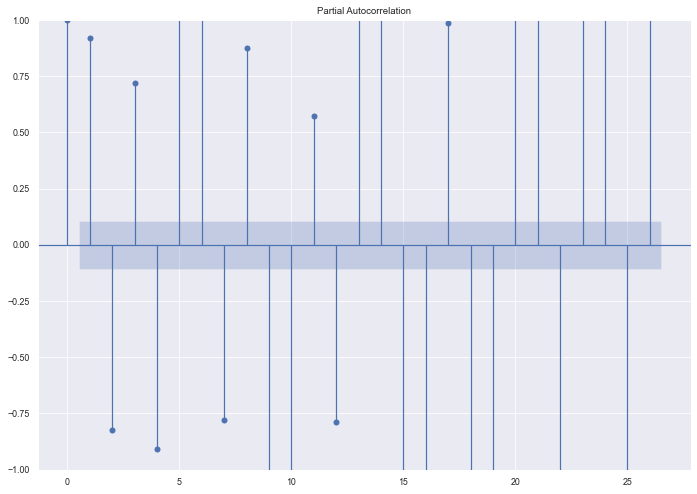

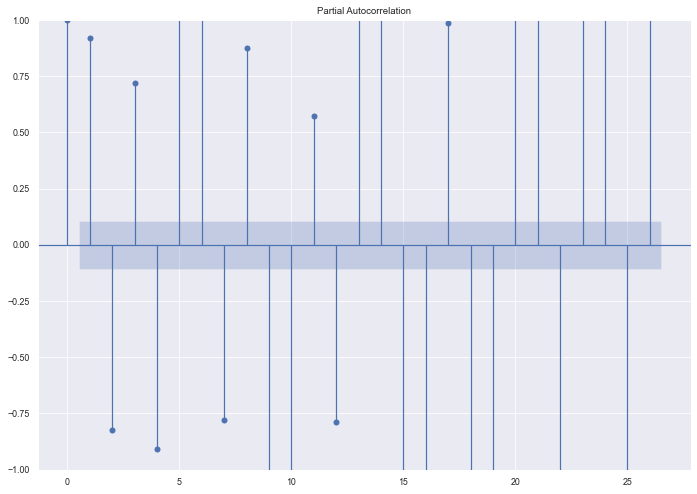

In [23]:
# Determining seasonal order
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller

plot_pacf(df.players)



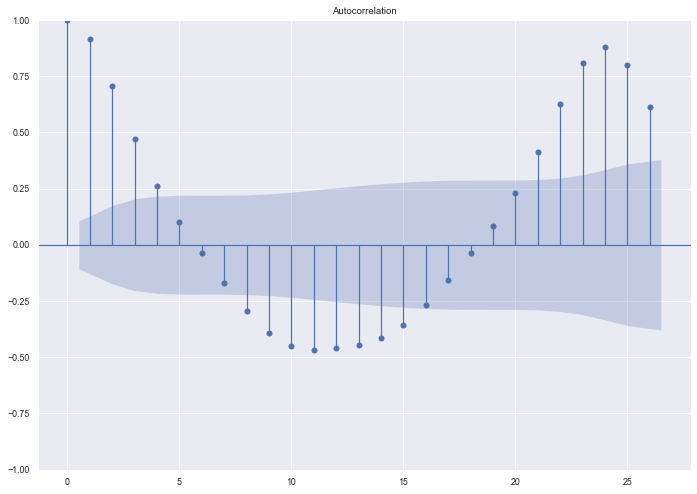

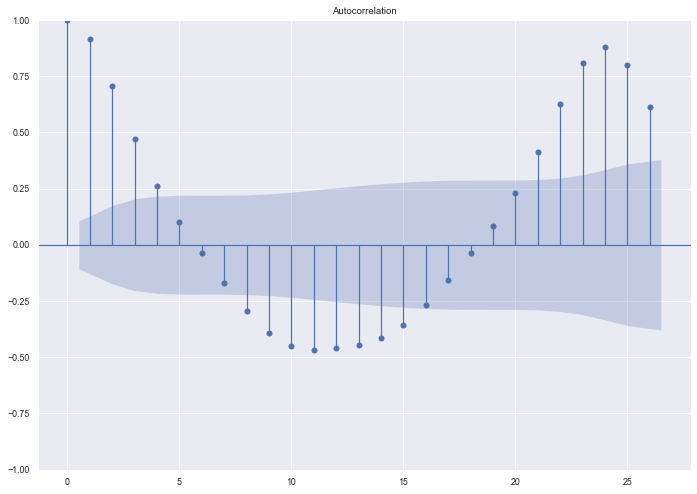

In [24]:
plot_acf(df.players)

In [25]:
## ARIMA Model: Determine AR model
import warnings
warnings.filterwarnings("ignore")

model = auto_arima(df.train.dropna(), trace=True, surpress_warnings=True)
model.summary()


#print(res.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6605.446, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=7632.139, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7081.760, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7416.512, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8317.792, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6653.103, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6663.191, Time=0.06 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6595.454, Time=0.12 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6603.427, Time=0.12 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=6592.990, Time=0.23 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=6600.036, Time=0.19 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=6574.872, Time=0.29 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=6558.960, Time=0.69 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  306
Model:               SARIMAX(5, 0, 4)   Log Likelihood               -3261.747
Date:                Fri, 01 Jul 2022   AIC                           6545.494
Time:                        22:58:59   BIC                           6586.453
Sample:                             0   HQIC                          6561.875
                                - 306                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.027e+04   1.84e+04      1.649      0.099   -5704.018    6.62e+04
ar.L1          0.8316      0.083     10.066      0.000       0.670       0.994
ar.L2         -0.5222      0.061     -8.534      0.000      -0.642      -0.402
ar.L3          0.9209      0.040     22.824      0.000       0.842       1.000
ar.L4         -0.8541      0.073    -11.738      0.000      -0.997      -0.711
ar.L5          0.4566      0.069      6.584      0.000       0.321       0.593
ma.L1          1.6867      0.088     19.171      0.000       1.514       1.859
ma.L2          2.2152      0.149     14.898      0.000       1.924       2.507
ma.L3          1.2654      0.147      8.623      0.000       0.978       1.553
ma.L4          0.5403      0.081      6.689      0.000       0.382       0.699
sigma2      1.094e+08     10.067   1.09e+07      0.000    1.09e+08    1.09e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                17.01
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.51
Prob(H) (two-sided):                  0.56   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.31e+26. Standard errors may be unstable.
"""

In [26]:
model = ARIMA(df.train.values, order=(5,0,4), seasonal_order=(0,0,0,0)).fit()
#model = model.fit()
preds = model.predict(start=len(df.train.dropna()), end=len(df.players)-1, typ='levels')
#print(preds)

df['arima_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds

def arima_model(train: pd.DataFrame, test: pd.DataFrame, order: tuple = (2, 1, 2)) -> List[any]:
    """ Trains an autoregression model to forecast future time series values.

    Args:
        train (pd.DataFrame): _description_
        test (pd.DataFrame): _description_

    Returns:
        List[any]: _description_
    """


    arma = ARIMA(train, (2,2)).fit(disp=False)
    preds = arma.predict(test)

    return preds



In [27]:
# print(preds)

# All the predictions stored into the dataframe
#df['naive_pred'] = np.repeat(np.nan, TRAIN_SIZE) + preds
df['arima_pred'] = np.nan
df.iloc[TRAIN_SIZE:,-1:] = preds

Text(0.5, 1.0, 'Player Activity Predictation: RMSE: 59590.36, MAPE: 0.39')

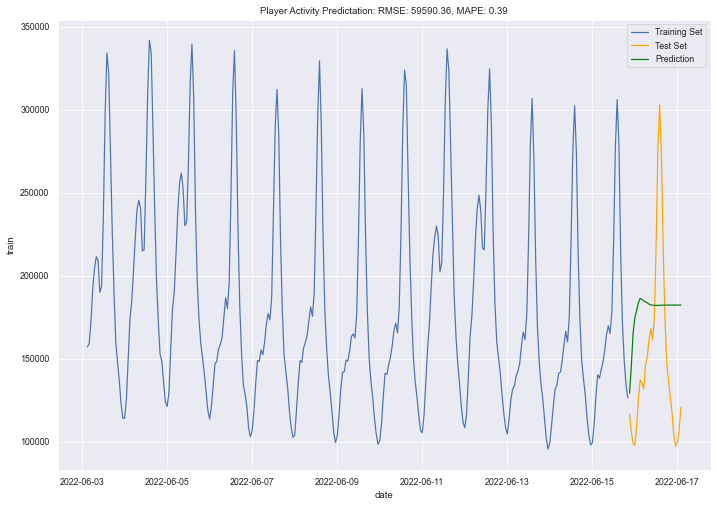

In [28]:
# Computes the mean percentage error and root mean square error for arima model
arima_rmse = rmse(df.test[TRAIN_SIZE:], df.arima_pred[TRAIN_SIZE:]) 
arima_mape = mean_absolute_percentage_error(df.test[TRAIN_SIZE:], df.arima_pred[TRAIN_SIZE:])

fig = sns.lineplot(data=df.train, label="Training Set")
sns.lineplot(data=df.test, color='orange', label="Test Set")
sns.lineplot(data=df.arima_pred, color="green", label="Prediction")

fig.set_title(f"Player Activity Predictation: RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}")

## FB Prophet Model

FB Prophet is a model developed by FB for in house predictions of time series values for different business applications. 

y_t = g(t) + s(t) + h(t) + e_t

Similar to the ARIMA model the FB Prophet uses trend, seasonality and additionally a holiday component with an error/noise component.
One of the advantages of the FB Prophet model is that the model provides upper and lower bound for the prediction with an additional component for holidays that the ARIMA model doesn't account for. However we will soon see that the FB Prophet model tends to overexagerate down trends.

In [29]:
# Format dataframe so that FB Prophet will accept where ds is the date column and y is the values column.
clean_df = df[['ds', 'players']] 
clean_df = clean_df.reset_index().drop(columns=['date'])
clean_df.columns = ['ds', 'y']
clean_df

,ds,y
0,2022-06-03 03:00:00,157067
1,2022-06-03 04:00:00,159168
2,2022-06-03 05:00:00,172103
3,2022-06-03 06:00:00,191923
4,2022-06-03 07:00:00,204307
...,...,...
331,2022-06-16 22:00:00,103678
332,2022-06-16 23:00:00,97250
333,2022-06-17 00:00:00,99135
334,2022-06-17 01:00:00,106913


22:59:11 - cmdstanpy - INFO - Chain [1] start processing
22:59:12 - cmdstanpy - INFO - Chain [1] done processing


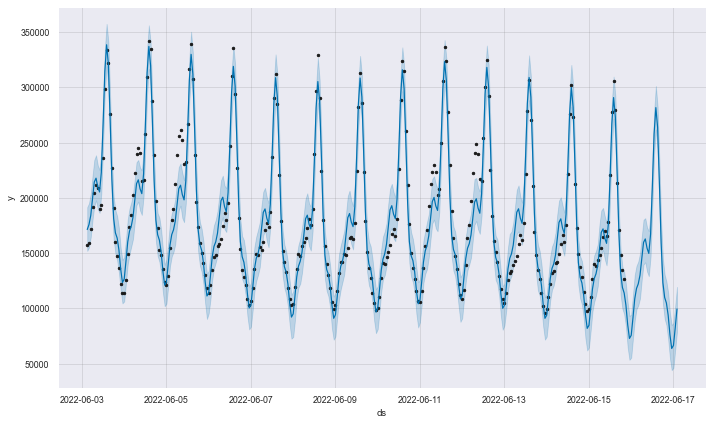

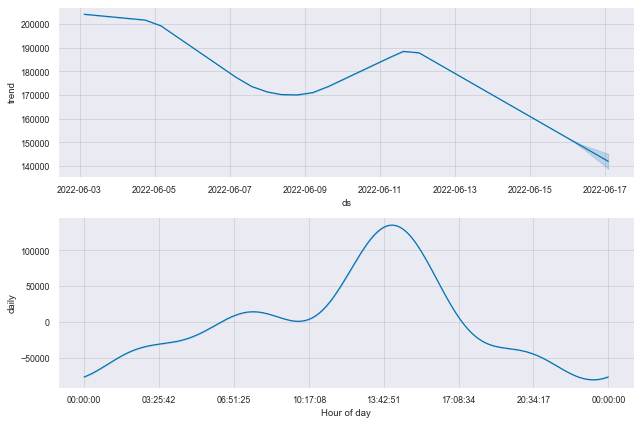

In [30]:
from prophet import Prophet

m = Prophet()
m.fit(clean_df[:-30])  # df is a pandas.DataFrame with 'y' and 'ds' columns
future = m.make_future_dataframe(periods=30, freq='h')
preds = m.predict(future)


preds[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
# Plotting predictions
fig1 = m.plot(preds)

# Plot daily seasonality and trend
fig2 = m.plot_components(preds)


# Set index to ds
preds = preds.set_index('ds')

Text(0.5, 1.0, 'FB Prophent Model: Player Activity Predictation | RMSE: 19120.32, MAPE: 0.13')

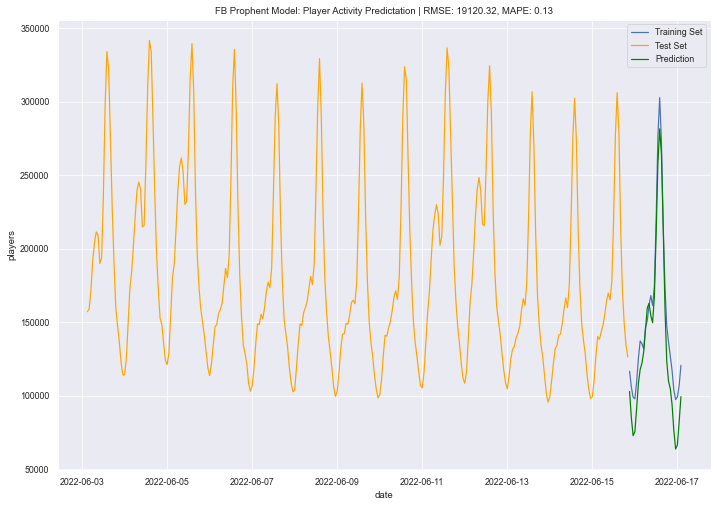

In [31]:
# Evaluating the performance of the fb prophet model
# Computes the mean percentage error and root mean square error for FB prophet model
arima_rmse = rmse(df.players[TRAIN_SIZE:], preds[TRAIN_SIZE:]['yhat']) 
arima_mape = mean_absolute_percentage_error(df.players[TRAIN_SIZE:], preds[TRAIN_SIZE:]['yhat'])

fig = sns.lineplot(data=df.players[TRAIN_SIZE:], label="Training Set")
sns.lineplot(data=df.players[:TRAIN_SIZE], color='orange', label="Test Set")
sns.lineplot(data=preds[TRAIN_SIZE:]['yhat'], color="green", label="Prediction")

fig.set_title(f"FB Prophent Model: Player Activity Predictation | RMSE: {arima_rmse:.2f}, MAPE: {arima_mape:.2f}")



## Discussion on FB Prophet Model

The FB Prophet model do well considering that unlike the LSTM model there is less hyperparameter tuning involved. The accuracy of the model is 87% with RMSE ~19120. One noticable trend in the FB Prophet model is the exageration of the down trends. 

While the FB Prophet model does well it does not beat the performance of the autoregression model. However for the autogression model a requirement was a solid understanding of the underlying data. Whereas the FB Prophet model did not require us to understand any of the data.

In [32]:
# # FB Prophet model

# def fb_prophet_model(train: pd.DataFrame, test: pd.DataFrame) -> None:

#     # Format dataframe so that FB Prophet will accept where ds is the date column and y is the values column.
#     #train = train[['ds', 'players']] 
#     train = train.reset_index()
#     train = train[['date', 'players']]
#     train.columns = ['ds', 'y']

#     #print(train)

#     test = test.reset_index()
#     test = test[['date', 'players']]
#     test.columns = ['ds', 'y']

#     #print(test)

#     #print(test)
#     # Train the fb prophet model
#     m = Prophet()
#     m.fit(train)  # df is a pandas.DataFrame with 'y' and 'ds' columns
#     future = m.make_future_dataframe(periods=test.shape[0], freq='h')
#     preds = m.predict(future)
#     #print(preds[['yhat']][:-test.shape[0]])
    
#     return preds[['yhat']][:-test.shape[0]]

# # evaluate fb prophet model

# rmse_metrics = []
# mape_metrics = []

# tscv = TimeSeriesSplit(n_splits=4)

# for train_index, test_index in tscv.split(df):

#     cv_train = df.iloc[train_index]
#     cv_test = df.iloc[test_index]

#     print(cv_train[:-1].shape[0])
#     print(preds.shape[0])

#     preds = fb_prophet_model(cv_train.players, cv_test)


#     rmse_eval = rmse(cv_test.players, preds[:-1]) 
#     naive_eval = mean_absolute_percentage_error(cv_test.players, preds[:-1])

#     rmse_metrics.append(rmse_eval)
#     mape_metrics.append(naive_eval)


# print("Cross Validation Results: ")
# print(f"RMSE: {np.mean(rmse_metrics)}")
# print(f"MAPE: {np.mean(mape_metrics)}")

## LSTM Model

LSTM is recurrent neural network model. LSTM can work with any kind of data not just sequential data like time series. The key difference is that LSTM places more emphasis on the data that is most recent as supposed to values that are older. One of the most important tasks when developing a LSTM model is tuning hyperparametes such as how many LSTM cells to represent the sequence.

In [33]:
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

In [34]:
def lstm_model(params, input_shape):
	""" Trains a LSTM model given params/input shape and return the predictions 

	Args:
		params (_type_): _description_
		input_shape (_type_): _description_

	Returns:
		_type_: _description_
	"""
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=False))
	model.add(Dropout(rate=params["dropout"]))

	model.add(Dense(1))

	model.compile(loss=params["loss"],
				optimizer=params["optimizer"],
				metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model

In [35]:
# Hyperparameters for LSTM model
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"lstm_units": 90,
	"epochs": 30,
	"batch_size": 128,
	"es_patience" : 10
}

# Create LSTM model
model = lstm_model(params=params, input_shape=len(df.train.dropna()))

In [36]:
df[['ds', 'players']]

,ds,players
date,,
2022-06-03 03:00:00,2022-06-03 03:00:00,157067
2022-06-03 04:00:00,2022-06-03 04:00:00,159168
2022-06-03 05:00:00,2022-06-03 05:00:00,172103
2022-06-03 06:00:00,2022-06-03 06:00:00,191923
2022-06-03 07:00:00,2022-06-03 07:00:00,204307
...,...,...
2022-06-16 22:00:00,2022-06-16 22:00:00,103678
2022-06-16 23:00:00,2022-06-16 23:00:00,97250
2022-06-17 00:00:00,2022-06-17 00:00:00,99135


In [38]:
# Early stopping (Stops the training if RMSE does not improve)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                              mode='min', patience=params["es_patience"])

# Split time series data into train/test set

tscv = TimeSeriesSplit()


# TODO: Fix code to follow dry principles (how to handle the state of the dataframe)
for train_index, test_index in tscv.split(df[['ds', 'players']]):
	print("TRAIN:", train_index, "TEST:", test_index)
	cv_train = df[['ds', 'players']].iloc[train_index]
	cv_test = df[['ds', 'players']].iloc[test_index]

# Fit model to dataset
model.fit(
	cv_train['ds'],
	cv_train['players'],
	validation_data=(cv_test['ds'], cv_test['players']),
	epochs=params["epochs"],
	batch_size=params["batch_size"],
	verbose=1,
	callbacks=[early_stop]
)

# Predictions from the LSTM model

TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55] TEST: [ 56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111] TEST: [112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported numpy type: NPY_DATETIME).